In [1]:
import os
import sys
import copy
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import soundfile as sf
import soxr

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model

sys.path.append('/om2/user/msaddler/spatial_audio_pipeline/spatial_audio_util')
import util_audio

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_figures_cnn
import util_stimuli
import util_misc


2023-09-14 22:22:10.990139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 22:22:13.665372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/foreground_swc/022_animals.wav'
y, sr = sf.read(fn)
dur = 2.0

df_brir = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_brir.pdpkl')
df_brir = df_brir[np.logical_and.reduce([
    df_brir.index_room == 0,
    df_brir.src_dist == 1.4,
    df_brir.src_elev.isin([0]),
    df_brir.src_azim.isin([360-45]),
])]
index_brir = df_brir.index[0]
brir, sr_brir = util_audio.load_brir(
    index_room=0,
    index_brir=index_brir,
    fn_pattern='/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/room{:04.0f}.hdf5',
    return_metadata=False,
    verbose=False)
assert sr_brir == sr

y = util_stimuli.pad_or_trim_to_len(y, int(dur * sr))
y = util_audio.spatialize_sound(y, brir[0])
y = util_stimuli.set_dBSPL(y, 75)

ipd.display(ipd.Audio(rate=sr, data=y.T))


In [4]:
kwargs_nervegram = {
    "IhcLowPass_cutoff": 3000,
    "IhcLowPass_order": 7,
    "bandwidth_scale_factor": 1.0,
    "buffer_end_dur": 0.0,
    "buffer_start_dur": 0.0,
    "cf_list": None,
    "cihc": 1.0,
    "cohc": 1.0,
    "implnt": 0,
    "max_cf": 16000.0,
    "max_spikes_per_train": 1000,
    "min_cf": 125,
    "nervegram_dtype": "float16",
    "nervegram_dur": 1.0,
    "nervegram_fs": 10000.0,
    "nervegram_spike_tensor_fs": 100000.0,
    "noiseType": 0,
    "num_cf": 50,
    "num_spike_trains": 1,
    "pin_dBSPL": None,
    "pin_dBSPL_flag": 0,
    "pin_fs": 100000.0,
    "random_seed": None,
    "return_meanrates": True,
    "return_spike_tensor_dense": False,
    "return_spike_tensor_sparse": False,
    "return_spike_times": False,
    "return_vihcs": False,
    "species": 2,
    "spont": [
        70.0,
        4.0,
        0.1
    ],
    "synapseMode": 0,
    "tabs": 0.0006,
    "trel": 0.0006
}

out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
len(out_dict)


27

In [5]:
fn_arch = '../saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_0000/arch.json'
layer_list = util_figures_cnn.process_cnn_layer_list(
    fn_arch=fn_arch,
    input_shape=[50, 20000],
    n_classes_dict={"label_word_int": 794})


2023-09-14 22:23:26.166199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11386 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1


In [9]:
# input_image = out_dict['nervegram_meanrates']
input_image = out_dict['nervegram_meanrates'][:, :, :, 0]
print(input_image.shape)
if input_image.ndim > 3:
    input_image = np.concatenate([
        input_image[..., 0],
        input_image[..., 1]
    ], axis=-1)
print(input_image.shape)


(50, 10000, 3)
(50, 10000, 3)


In [7]:
import matplotlib.patches
import matplotlib.transforms

from util_figures_cnn import *

def draw_cnn_from_layer_list(ax,
                             layer_list,
                             scaling_w='log2',
                             scaling_h='log2',
                             scaling_n='log2',
                             include_kernels=True,
                             input_image=None,
                             input_image_shape=None,
                             gap_input_scale=2.0,
                             gap_interlayer=2.0,
                             gap_intralayer=0.2,
                             gap_output=0,
                             deg_scale_x=60,
                             deg_skew_y=30,
                             deg_fc=0,
                             range_w=None,
                             range_h=None,
                             kernel_x_shift=-0.75,
                             kernel_y_shift=0.75,
                             limits_buffer=1e-2,
                             arrow_width=0.25,
                             scale_fc=1.0,
                             spines_to_hide=['top', 'bottom', 'left', 'right'],
                             kwargs_imshow_update={},
                             kwargs_polygon_update={},
                             kwargs_polygon_kernel_update={},
                             kwargs_polygon_kernel_line_update={},
                             kwargs_arrow_update={},
                             binaural=4):
    '''
    Main function for drawing CNN architecture schematic.
    '''
    # Define and update default keyword arguments for matplotlib drawing
    kwargs_imshow = {
        'cmap': matplotlib.cm.gray,
        'aspect': 'auto',
        'origin': 'lower',
        'alpha': 1.0,
    }
    kwargs_imshow.update(kwargs_imshow_update)
    kwargs_polygon = {
        'ec': [0.0]*3,
        'fc': [0.6]*3,
        'lw': 1.0,
        'fill': True,
        'alpha': 1.0,
    }
    kwargs_polygon.update(kwargs_polygon_update)
    kwargs_polygon_kernel = copy.deepcopy(kwargs_polygon)
    kwargs_polygon_kernel['alpha'] = 0.5
    kwargs_polygon_kernel['fc'] = [0.0, 1.0, 0.0]
    kwargs_polygon_kernel['lw'] = 0.0
    kwargs_polygon_kernel['fill'] = True
    kwargs_polygon_kernel.update(kwargs_polygon_kernel_update)
    kwargs_polygon_kernel_line = {
        'alpha': 1.0,
        'color': kwargs_polygon_kernel['fc'],
        'lw': 1.0,
    }
    kwargs_polygon_kernel_line.update(kwargs_polygon_kernel_line_update)
    kwargs_arrow = {
        'width': arrow_width,
        'length_includes_head': True,
        'head_width': arrow_width * 2.5,
        'head_length': arrow_width * 2.5,
        'overhang': 0.0,
        'head_starts_at_zero': False,
        'color': 'k',
    }
    kwargs_arrow.update(kwargs_arrow_update)
    kwargs_arrow_gap = copy.deepcopy(kwargs_arrow)
    kwargs_arrow_gap['head_width'] = 0
    kwargs_arrow_gap['head_length'] = 0
    kwargs_transform = {'deg_scale_x': deg_scale_x, 'deg_skew_y':deg_skew_y}
    
    # Define coordinate tracker variables
    (xl, yl, zl) = (0, 0, 0)
    
    # Display the input image
    assert input_image is not None, "input_image is currently a required argument"
    while len(input_image.shape) < 3:
        input_image = input_image[..., np.newaxis]
    input_image_shape = input_image.shape
    w = get_dim_from_raw_value(input_image_shape[1], range_dim=range_w, scaling=scaling_w)
    h = get_dim_from_raw_value(input_image_shape[0], range_dim=range_h, scaling=scaling_h)
    n_channel = input_image.shape[-1]
    for itr_channel in range(n_channel):
        if binaural:
            if itr_channel < n_channel / 2:
                kwargs_imshow.update({'cmap': 'Blues_r'})
            else:
                kwargs_imshow.update({'cmap': 'Reds_r'})
        extent = np.array([xl-w/2, xl+w/2, yl-h/2, yl+h/2])
        im = ax.imshow(
            input_image[:, :, itr_channel],
            extent=extent,
            zorder=zl,
            **kwargs_imshow)
        args_image = {
            'x': xl,
            'y': yl,
            'w': w,
            'h': h,
            'zorder': zl,
            'shape': [input_image_shape[0], input_image_shape[1]],
        }
        zl += 1
        transform = get_affine_transform(center=(xl, yl), **kwargs_transform)
        im.set_transform(transform + ax.transData)
        M = transform.transform(extent.reshape([2, 2]).T)
        dx_arrow = np.min([M[-1, 0]-xl, gap_interlayer * gap_input_scale])
        ax.arrow(x=xl, y=yl, dx=dx_arrow, dy=0, zorder=zl, **kwargs_arrow_gap)
        if itr_channel < n_channel - 1:
            xl += gap_intralayer * gap_input_scale * 2
        zl += 1
        
#         # Quick hack to ensure that ax.dataLim.bounds accounts for input image
#         [xb, yb, dxb, dyb] = ax.dataLim.bounds
#         xb_error = np.min(M[:, 0]) - xb
#         ax.dataLim.bounds = [xb+xb_error, yb, 0, dyb]
    
    xl += gap_interlayer * gap_input_scale
    
    # Display the network architecture
    kernel_to_connect = False
    for itr_layer, layer in enumerate(layer_list):
        # Draw convolutional layer
        if 'conv' in layer['layer_type']:
            # Draw convolutional kernel superimposed on previous layer
            if include_kernels:
                args_kernel = {
                    'shape': layer['shape_kernel'],
                }
                ax, args_image, args_kernel = draw_conv_kernel_on_image(
                    ax,
                    args_image=args_image,
                    args_kernel=args_kernel,
                    kwargs_polygon_kernel=kwargs_polygon_kernel,
                    kwargs_polygon_kernel_line=kwargs_polygon_kernel_line,
                    kwargs_transform=kwargs_transform,
                    kernel_x_shift=kernel_x_shift,
                    kernel_y_shift=kernel_y_shift)
                kernel_to_connect = True
            # Draw convolutional layer activations as stacked rectangles
            [h, w, n] = layer['shape_activations']
            n = int(get_dim_from_raw_value(n, range_dim=None, scaling=scaling_n))
            if n % 2 == 1:
                n += 1
            w = get_dim_from_raw_value(w, range_dim=range_w, scaling=scaling_w)
            h = get_dim_from_raw_value(h, range_dim=range_h, scaling=scaling_h)
            for itr_sublayer in range(n):
                xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
                if binaural:
                    kwargs_polygon_binaural = dict(kwargs_polygon)
                    if (itr_layer <= binaural) and (itr_sublayer < n / 2):
                        kwargs_polygon_binaural.update({
                            'ec': [0, 0, 1],
                            'fc': [0.5, 0.5, 0.6],
                        })
                    elif (itr_layer <= binaural) and (itr_sublayer >= n / 2):
                        kwargs_polygon_binaural.update({
                            'ec': [1, 0, 0],
                            'fc': [0.6, 0.5, 0.5],
                        })
#                     elif (itr_layer > binaural):
#                         kwargs_polygon_binaural.update({
#                             'ec': [0.25, 0, 0.25],
#                         })
                    patch = matplotlib.patches.Polygon(xy, **kwargs_polygon_binaural, zorder=zl)
                else:
                    patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
                transform = get_affine_transform(center=(xl, yl), **kwargs_transform)
                patch.set_transform(transform + ax.transData)
                ax.add_patch(patch)
                args_image = {
                    'x': xl,
                    'y': yl,
                    'w': w,
                    'h': h,
                    'zorder': zl,
                    'shape': layer['shape_activations'][0:-1],
                }
                if kernel_to_connect:
                    # If a convolutional kernel was drawn, add connecting lines to the following layer
                    vertex_output_x = args_image['x'] + args_kernel['x_shift'] * (args_image['w'] / 2)
                    vertex_output_y = args_image['y'] + args_kernel['y_shift'] * (args_image['h'] / 2)
                    vertex_output = transform.transform(np.array([vertex_output_x, vertex_output_y]))
                    for vertex_input in args_kernel['vertices']:
                        ax.plot(
                            [vertex_input[0], vertex_output[0]],
                            [vertex_input[1], vertex_output[1]],
                            **kwargs_polygon_kernel_line,
                            zorder=args_kernel['zorder'])
                    kernel_to_connect = False
                if itr_sublayer == n-1:
                    dx_arrow = transform.transform(xy)[-1, 0]-xl
                    ax.arrow(
                        x=xl,
                        y=yl,
                        dx=dx_arrow,
                        dy=0,
                        zorder=zl,
                        **kwargs_arrow_gap)
                    zl += 1
                zl += 1
                xl += gap_intralayer
            xl += gap_interlayer
        # Draw fully-connected layer
        elif ('dense' in layer['layer_type']) or ('top' in layer['layer_type']):
            xl += gap_output
            n = layer['shape_activations'][0]
            w = gap_intralayer
            h = get_dim_from_raw_value(n, range_dim=None, scaling=scaling_n) * scale_fc
            xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
            patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
            patch_im = ax.add_patch(patch)
            zl += 1
            xl += gap_interlayer
    
    # Draw underlying arrow and format axes
    ax.arrow(x=0, y=yl, dx=xl, dy=0, **kwargs_arrow, zorder=-1)
    ax.update_datalim([[0, yl], [xl, yl]])
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    ax.set_xlim([xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb])
    ax.set_ylim([yb - limits_buffer * dyb, yb + (1 + limits_buffer) * dyb])
    ax.set_xticks([])
    ax.set_yticks([])
    for spine_key in spines_to_hide:
        ax.spines[spine_key].set_visible(False)
    return ax


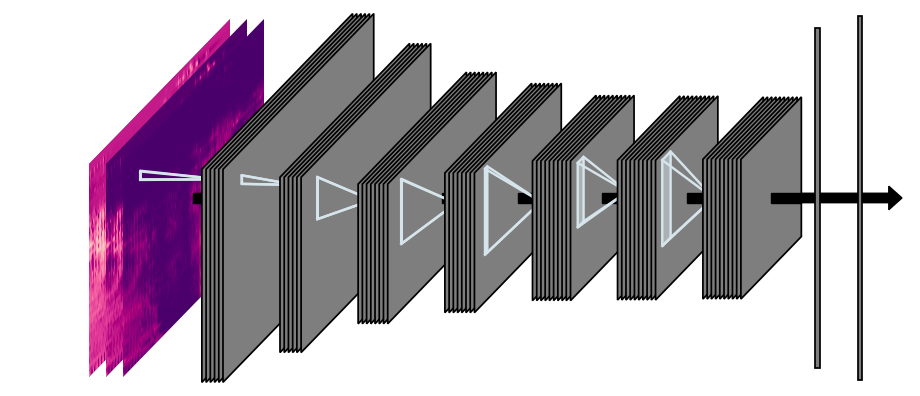

In [17]:
color = np.array([215, 229, 236]) / 256
color_body = np.array([126] * 3) / 256
kwargs_polygon_kernel_update = {'fc': color}
kwargs_polygon_kernel_line_update = {'lw': 1.75, 'color': color}
kwargs_polygon_update = {'lw': 1.25, 'fc': color_body}

binaural = 0
if input_image.shape[-1] <= 3:
    binaural = 0
# if binaural:
#     kwargs_polygon_update = {
#         'lw': 1.25,
#         'fc': [0.6, 0.5, 0.6],
#         'ec': 'purple',
#     }

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
ax = draw_cnn_from_layer_list(
    ax,
    layer_list,
    deg_scale_x=60,
    deg_skew_y=30,
    scaling_w='log2',
    scaling_h='log2',
    scaling_n='log2',
    binaural=binaural,
    input_image=input_image,
    kwargs_imshow_update={'cmap': 'RdPu_r'},
    kwargs_polygon_update=kwargs_polygon_update,
    kwargs_polygon_kernel_update=kwargs_polygon_kernel_update,
    kwargs_polygon_kernel_line_update=kwargs_polygon_kernel_line_update)

[xb, yb, dxb, dyb] = ax.dataLim.bounds
fig_factor = 2
fig.set_size_inches(dxb/(fig_factor*1.8), dyb/fig_factor)
plt.show()

# fn_fig = 'figures_src/cnn_monaural_spont_altered.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0, transparent=True)


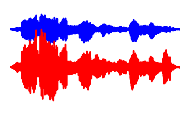

In [55]:
fig, ax = plt.subplots(figsize=(2, 1.25))

t = np.arange(0, len(y)) / sr
TIDX = np.logical_and(t >= 0.6, t<= 1.75)
ax.plot(t[TIDX], y[TIDX, 0] + y[TIDX].max(), color='b', lw=1)
ax.plot(t[TIDX], y[TIDX, 1], color='r', lw=1)
ax = util_figures.format_axes(
    ax,
    xlimits=[t[TIDX][0], t[TIDX][-1]],
    yticks=[],
    xticks=[],
    spines_to_hide=['top', 'bottom', 'right', 'left'])
plt.tight_layout()

# fn_fig = 'figures_src/cnn_input_binaural.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0, transparent=True)


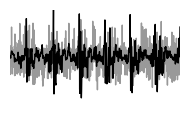

In [89]:
fig, ax = plt.subplots(figsize=(2, 1.25))

pitch = True
np.random.seed(0)
t = np.arange(0, len(y)) / sr
TIDX = np.logical_and(t >= 0.6, t<= 1.75)
if pitch:
    TIDX = np.logical_and(t >= 0.8, t<= 0.85)
noise = y[TIDX, 0] * 2
np.random.shuffle(noise)
ax.plot(t[TIDX], noise, color=[0.6] * 3, lw=1)
ax.plot(t[TIDX], y[TIDX, 1], color='k', lw=1)
ax = util_figures.format_axes(
    ax,
    xlimits=[t[TIDX][0], t[TIDX][-1]],
    ylimits=[-np.abs(y).max(), np.abs(y).max()],
    yticks=[],
    xticks=[],
    spines_to_hide=['top', 'bottom', 'right', 'left'])
plt.tight_layout()

# fn_fig = 'figures_src/cnn_input_monaural_pitch.pdf'
# fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0, transparent=True)
